# SVM via Tensorflow

Reference:
* [SMO优化算法（Sequential minimal optimization)](http://www.cnblogs.com/jerrylead/archive/2011/03/18/1988419.html)
* [SVM原理以及Tensorflow 实现SVM分类(附代码)](https://www.cnblogs.com/vipyoumay/p/7560061.html)
* [知乎实现SVM的SMO](https://zhuanlan.zhihu.com/p/29212107)
* [Latex Symbols](https://artofproblemsolving.com/wiki/index.php/LaTeX:Symbols)

## 1. Theory

Given $(X_i, y_i), y_i=+1/-1,$ we try to maximize 
$$ \gamma = \frac{|W^T \cdot X + b|}{||W||}$$
With restriction
$$ 
\begin{cases}
    W^T \cdot X_i + b \geq +1, & \text{if } y_i=1\\ 
    W^T \cdot X_i + b \leq -1, & \text{if } y_i=-1
\end{cases}
$$

### 1.1 Equation Formalization
Using mathmetic refactoration, we get our **SVM algorithm goal formalized** as follow:
$$
\begin{equation}
\max_{W,b} \frac{2}{||W||}, \\
\text{ s.t. } y_i(W^T \cdot X_i + b) \geq 1, i = 1,2,...,m
\end{equation}
$$

Futhermore, $||w|| > 0$, we can equally use:
$$
\begin{equation}
\min_{W,b} \frac{||W||^2}{2}, \\
\text{ s.t. } y_i(W^T \cdot X_i + b) \geq 1, i = 1,2,...,m
\end{equation}
$$

### 1.2 Dual Problem
$$ L(W, b, \alpha) = \frac{1}{2}||W||^2 + \sum_{i=1}^{m} \alpha_i [1-y_i(W^T \cdot X_i + b)], \text{   }\alpha=(\alpha_1;\alpha_2;...;\alpha_m)$$
Make partial devative for W and b, get as follow:
$$ W = \sum_{i=1}^{m} \alpha_i y_i x_i $$
$$ 0 = \sum_{i=1}^{m} \alpha_i y_i $$

Then get into $ L(W, b, \alpha) $, we get SVM dual problem as follow:
$$ \max_{\alpha} W(\alpha) = \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha_i \alpha_j y_i y_j x_i^T x_j $$ 
$$ \text{   s.t.} \sum_{i=1}^m \alpha_i y_i = 0, 0 \leq \alpha_i \leq C, i=1,2,...,m$$

* **Algorithm**  
Repeat till converge:
    1. Select $\alpha_i$ and $\alpha_j$ to update next (using heuristic to make bigger progress)
    2. Reoptimize $W(\alpha)$ with respect to $\alpha_i$ and $\alpha_j$, while holding $\alpha_k, (k \not\equiv i, j)$ fixed
    
* **Implementation**
$$ \alpha_1 y^{(1)} + \alpha_2 y^{(2)} = - \sum_{i=3}^m \alpha_i y^{(i)} $$
make $ \alpha_1 y^{(1)} + \alpha_2 y^{(2)} = \zeta $, We analyze ($\alpha_1, \alpha_2$) as the following 2 cases:

**Case 1**: $ y^{(1)} \cdot y^{(2)} = -1 $, we have
    <img src="svm_bound.png" width="45%"/>

$ L = \max(0, \alpha_2 - \alpha_1), H = \min(C, C + \alpha_2 - \alpha_1) $

**Case 2**: $ y^{(1)} \cdot y^{(2)} = +1 $, we have

$ L = \max(0, \alpha_2 + \alpha_1 - C), H = \min(C, \alpha_2 + \alpha_1) $

Also summarize for **Case 1** and **Case 2**, $k$ is the same as $\zeta$
    <img src="https://pic3.zhimg.com/80/v2-449670775bab3c385b5e5930fc6d2caa_hd.png" width="55%"/>

Then we use $\alpha_2$ to represent $\alpha_1$:

$ \alpha_1 = (\zeta - \alpha_2 y^{(2)}) y^{(1)} $

Put $ \alpha_1 $ into $W(\alpha)$, we get:

$$ W(\alpha_1, \alpha_2, ..., \alpha_m) = W((\zeta - \alpha_2 y^{(2)}) y^{(1)} ,\alpha_2, ..., \alpha_m)$$

$W((\zeta - \alpha_2 y^{(2)}) y^{(1)} ,\alpha_2, ..., \alpha_m)$ is a kind of $a \alpha_2^2 + b \alpha_2 + c$, then use paritial deviation of $W(\alpha)$ to get $\alpha_2$, in symbol $\alpha_2| \frac{\partial W}{\partial \alpha_2}$. considering $ L \leq \alpha_2 \leq H$, we use $\alpha_2^{new,unclipped}$ to represent $\alpha_2| \frac{\partial W}{\partial \alpha_2}$, take case condition as follow:

$$
\alpha_2^{new} =
\begin{cases}
H, \text{  if  } \alpha_2^{new,unclipped} > H \\
\alpha_2^{new,unclipped}, \text{  if  } L \leq \alpha_2^{new,unclipped} \leq H \\
L, \text{  if  } \alpha_2^{new,unclipped} < L \\
\end{cases}
$$

Sovle wtih $\alpha$, get W and b to get model:
$$ f(x) = W^T \cdot X + b = \sum_{i=1}^m \alpha_i y_i x_i^T X + b $$

Satisfy **KKT (Karush-Kuhn-Tucker) condition** as follow:
$$
\begin{cases}
\alpha_i \geq 0; \\
y_i f(x_i) - 1 \geq 0; \\
\alpha_i [y_i f(x_i) - 1] = 0.
\end{cases}
$$

### 1.3 Heursitic Search for Dual Problem

[Platt 1988's SMO Paper](https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/) use heurstic method to sovle Dual Problem.

* **1. Original Problem Definition**
$$ u = W \cdot X - b $$
 1. Original optimization problem:
$$
\begin{equation}
\min_{W,b} \frac{||W||^2}{2}, \\
\text{ s.t. } y_i(W^T \cdot X_i - b) \geq 1, i = 1,2,...,m
\end{equation}
$$

 2. Partial devation to get solution of original problem:
$$ W = \sum_{i=1}^N y_i \alpha_i X_i, b = W X_k - y_k \text{ for some } \alpha_k > 0 $$

* **Lagrangian conversion**
$$ 
\min_{\alpha} \Psi(\alpha) = \min_{\alpha} \frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N y_i y_j (x_i \cdot x_j) \alpha_i \alpha_j - \sum_{i=1}^N \alpha_i
$$
$$ \forall i, \alpha_i \geq 0 $$
$$ \sum_{i=1}^N y_i \alpha_i = 0 $$

* **2. Modified SVM problem for non-Linear splitting with penalities**
$$
\min_{W,b, \xi} \frac{1}{2}||W||^2 + C \sum_{i=1}^N \xi_i
$$
$$ \text{   subject to } y_i(W X_i - b) \geq 1 - \xi_i, \forall i $$
$$ 0 \leq \alpha_i \leq C, \forall i $$

 If taking Kernel function into consideration, we can have $u$ as:
$$
\nu = \sum_{j=1}^N y_j \alpha_j K(x_j, x) - b
$$

* **Lagrangian conversion for Modified SVM problem**
$$ 
\min_{\alpha} \Psi(\alpha) = \min_{\alpha} \frac{1}{2}\sum_{i=1}^N \sum_{j=1}^N y_i y_j K(x_i \cdot x_j) \alpha_i \alpha_j - \sum_{i=1}^N \alpha_i
$$
$$ \forall i, \alpha_i \geq 0 $$
$$ \sum_{i=1}^N y_i \alpha_i = 0 $$

 **KKT condition**
$$ \alpha_i = 0 \iff y_i \nu_i \geq 1 $$
$$ 0 < \alpha_i < C \iff y_i \nu_i = 1 $$
$$ \alpha_i = C \iff y_i \nu_i \leq 1 $$

### 1.4 b Value for Dual Problem

* As $\alpha_i >0$, we have $y_i f(x_i) = 1$, then such $(x_i, y_i)$ is a **supported vector**, make it as $(x_s, y_s)$.

* For $\forall (x_s, y_s)$, they have fit for $y_i f(x_i) = 1$, summed together
$$ y_s (\sum_{i \in S} \alpha_i y_i X_i^T X_s + b) = 1, \text{   } S= \{i|\alpha_i > 0, i=1,2,...,m\} $$

* solve b value as follow:
$$ b = \frac{1}{|S|} \sum_{s \in S} (y_s - \sum_{i \in S} \alpha_i y_i X_i^T X_s) $$

## 2. Practise

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])

In [3]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, random_state=42)
for train_index, test_index in kf.split(x_vals, y_vals):
    X_train, y_train, X_test, y_test = x_vals[train_index], y_vals[train_index], x_vals[test_index], y_vals[test_index]

### 2.1 GD Tensorflow
### Use W, b to estimate SVM boundary

In [4]:
assert len(x_vals.shape) == 2 and len(y_vals.shape) == 1

In [5]:
from tensorflow.contrib.layers import xavier_initializer
from tensorflow.losses import mean_squared_error
from tensorflow.train import AdamOptimizer

tf.reset_default_graph()

X_data = tf.placeholder(tf.float32, shape=[None, x_vals.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, 1])

W = tf.get_variable(shape=[x_vals.shape[1], 1], name="W", initializer=xavier_initializer())
b = tf.get_variable(shape=[1, 1], name="b", initializer=xavier_initializer())

output = tf.matmul(X_data, W) - b
l2_norm = mean_squared_error(output, y_target)

$$ Loss = \max(0, 1 - \hat{y(i)} \cdot y(i)) + \alpha  ||X \cdot W - b||^2 $$

In [6]:
loss = tf.reduce_mean(tf.maximum(0., 1. - output * y_target)) + 0.01 * l2_norm
optimizer = AdamOptimizer(0.01).minimize(loss)

In [7]:
batch_size = 1024

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        rand_index = np.random.choice(len(X_train), size=batch_size)
        rand_x = X_train[rand_index]
        rand_y = np.transpose([y_train[rand_index]])
        sess.run(optimizer, feed_dict={X_data: rand_x, y_target: rand_y})
    [[a1], [a2]] = sess.run(W)
    [[b]] = sess.run(b)

### Draw Boundary

Text(0,0.5,'Sepal Length')

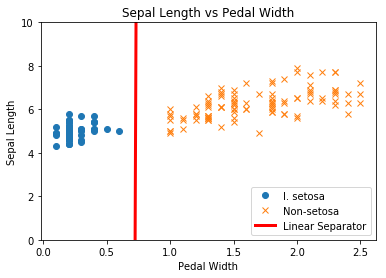

In [8]:
slope = -a2/a1
y_intercept = b/a1
best_fit = []

x1_vals = [d[1] for d in x_vals]

for i in x1_vals:
    best_fit.append(slope*i+y_intercept)

# Separate I. setosa
setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]
not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]

plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
plt.ylim([0, 10])
plt.legend(loc='lower right')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')

## 2.2 SMO Tensorflow

#### SMO update equation from [Platt  1988 MSRA]

Details reasoning refer to [知乎SVM](https://zhuanlan.zhihu.com/p/29212107) and [Platt's SMO in appendix](https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/)

1. L, H values
$$
\begin{cases}
L = max(0, \alpha_2-\alpha_1), H=min(C, C+\alpha_2-\alpha_1) \text{   ,when   }y_2 y_1 = -1 \\
L = max(0, \alpha_2+\alpha_1-C), H=min(C, \alpha_2+\alpha_1) \text{   ,when   }y_2 y_1 = 1
\end{cases}
$$

2. Partial devative utility $\eta$  
$$
\eta = \kappa (x_1, x_1) + \kappa (x_2, x_2) - 2 \kappa (x_1, x_2)
$$
When $\kappa$ is linear, we have
$$
\kappa (x_1, x_2) = x_1^T \cdot x_2
$$

3. Quaradtic solution $\alpha_2^{new}$
$$
\alpha_2^{new} = \alpha_2 + \frac{y_2 (E_1 - E_2)}{\eta}
$$
Where $E_i$ is defined as:
$$
E_i = \nu_i - y_i, \nu_i = W \cdot X_i - b - y_i
$$

4. Solution clip
$$
\alpha_2^{new, clipped} = 
\begin{cases}
H, \text{  if  } \alpha_2^{new} \geq H \\
\alpha_2^{new}, \text{  if  } L \leq \alpha_2^{new} \leq H \\
L, \text{  if  } \alpha_2^{new} \leq H 
\end{cases}
$$

5. $\alpha_1^{new}$ update
$$
s = y_1 y_2
$$
$$
\alpha_1^{new} = \alpha_1 + s(\alpha_2 - \alpha_2^{new, clipped})
$$

6. Update parameters
$$
f_1 = y_1(E_1 + b) - \alpha_1 \kappa(x_1, x_1) - s \alpha_2 \kappa(x_1, x_2) \\
f_2 = y_2(E_2 + b) - s \alpha_1 \kappa(x_1, x_2) - \alpha_2 \kappa(x_2, x_2) \\
L_1 = \alpha_1 + s(\alpha_2 - L) \\
H_1 = \alpha_1 + s(\alpha_2 - H) \\
\Psi_L = L_1 f_1 + \frac{1}{2} L_1^2 \kappa(x_1, x_1) + \frac{1}{2}L^2 \kappa(x_2, x_2) + sL L_1 \kappa(x_1, x_2) \\
\Psi_H = H_1 f_1 + \frac{1}{2} H_1^2 \kappa(x_1, x_1) + \frac{1}{2}H^2 \kappa(x_2, x_2) + sH H_1 \kappa(x_1, x_2)
$$

7. Heuristics for choosing which multipliers to optimize

8. Compute the threshold
    * $b_1$ is valid when new $\alpha_1$ isn't at the bounds
    $$
    b_1 = E_1 + y_1(\alpha_1^{new} - \alpha_1) \kappa(x_1, x_!) + y_2 (\alpha_2^{new, clipped} - \alpha_2) \kappa(x_1, x_2) + b
    $$
    * $b_2$ is valid when new $\alpha_2$ isn't at the bounds
    $$
    b_2 = E_2 + y_1(\alpha_1^{new} - \alpha_1) \kappa(x_1, x_2) + y_2 (\alpha_2^{new, clipped} - \alpha_2) \kappa(x_2, x_2) + b
    $$
    * both $b_1$ and $b_2$ are valid, they are equal; so using b from $b_1$ and $b_2$ 
    $$
    b = (b_1 + b_2) / 2
    $$

9. Optimization for Linear SVMs
$$
W^{new} = W + y_1 (\alpha_1^{new} - \alpha_1) x_1 + y_2 (\alpha_2^{new, clipped} - \alpha_2) x_2
$$

In [ ]:
import tensorflow as tf
import numpy as np

class TFSVM():
    """
    Using tensorflow to implement SMO-SVM
    1. Paper: refer to https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/.
    2. Implementation via tensroflow: refer to https://blog.csdn.net/lilongsy/article/details/79391698.
    """
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=1e-3):
        """[initializer for tensorflow SVM]
        
        Keyword Arguments:
            max_iter {int} -- [max iteration number] (default: {10000})
            kernel_type {str} -- [kernel type] (default: {'linear'})
            C {float} -- [penality term] (default: {1.0})
            epsilon {float} -- [KKT boundary parameter to check if convergence] (default: {1e-3})
        """
        self._kernels = {
            "linear": self.kernel_linear
        }
        assert kernel_type in self._kernels
        self._max_iter = max_iter
        self._kernel_type = kernel_type
        self._C = C
        self._epsilon = epsilon
        self._model_available = False

    def fit(self, X_train: np.array, y_train: np.array):
        """[training process for (X_train, y_train)], different from you seeing online. I'd like to use tensorflow for SMO update process, as it's actually analytical solution.
        
        Arguments:
            X_train {np.array} -- [X input data]
            y_train {np.array} -- [y output data, only +1/-1 for classification]
        """
        raise NotImplementedError
        assert X_train.shape[0] == y_train.shape[0]
        # start training
        self._model_available = False
        # training process
        # after training
        self._model_available = True

    def score(self, X: np.array, y: np.array):
        """[return score of (X, y) based on svm trained model]
        
        Arguments:
            X {np.array} -- [feature array]
            y {np.array} -- [target value]
        
        Return:
            score {float} - [score of SVM model after evaluation of (X, y) pair]
        """
        if not self._model_available:
            raise ValueError("SVM model isn't available")
        raise NotImplementedError

    def predict(self, X: np.array):
        """[predict target value given X as input]
        
        Arguments:
            X {np.array} -- [feature array]

        Return:
            y_pred {np.array} - [predicted target value]
        """
        if not self._model_available:
            raise ValueError("SVM model isn't available")
        raise NotImplementedError

    ########################
    # Available SVM kernels 
    ########################
    def kernel_linear(self, x1: tf.Tensor, x2: tf.Tensor):
        """[linear kernel method for SVM]
        
        Arguments:
            x1 {tf.Tensor} -- [x1 vector]
            x2 {tf.Tensor} -- [x2 vector]
        
        Returns:
            [tf.Tensor] -- [tf.matmul(x1.T, x2)]
        """
        assert tf.shape(x1) == tf.shape(x2)
        return tf.matmul(tf.transpose(x1), x2)